# Deep Splicer: Genomic Sequence Classification

## Introduction
This notebook demonstrates the process of classifying genomic sequences using a convolutional neural network.

## Setup
Install necessary packages and import libraries.

In [ ]:
import math
import os
import time
from collections import Counter
import numpy as np
import pandas as pd
import seaborn as sn
import tensorflow as tf
import matplotlib.pyplot as plt
from itertools import cycle
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv1D, Conv2D
from tensorflow.keras.layers import AveragePooling2D, MaxPooling1D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam, Nadam
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow.keras.backend as K
from tensorflow.keras.metrics import top_k_categorical_accuracy
from tensorflow.keras.regularizers import l1, l2, l1_l2
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, roc_auc_score, auc, roc_curve, average_precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from ensemblrest import EnsemblRest

ensRest = EnsemblRest()

## Data Preprocessing
Load and preprocess the dataset.

In [2]:
# Change directory to the dataset location
os.chdir("homo_sapiens")

# Define constants
FLANKING_LEN = 200

# Define one-hot encoding function using numpy for efficiency
def one_hot_encode(seq):
    mapping = {'A': 0, 'C': 1, 'G': 2, 'T': 3, 'N': 4}
    seq = seq.upper()
    integer_encoded = np.array([mapping.get(base, 4) for base in seq])
    one_hot_encoded = np.eye(5)[integer_encoded]
    return one_hot_encoded[:, :4]  # Exclude the last column (for 'N')

# Define function to get numpy arrays
def get_np_array(oversampling=0, downsampling=0):
    data = {'donor': [], 'acceptor': [], 'other': []}
    flanking_length = FLANKING_LEN
    
    for type_seq in ['donor', 'acceptor', 'other']:
        for i in range(0, 19305, 1000):
            file_name = f"{type_seq}_seqs_{i}_{i+1000}_flank_{flanking_length}.txt"
            with open(file_name) as fle:
                seqs = [line[2:].rstrip() for line in fle if line.startswith(">>")]
            data[type_seq].extend(seqs)
    
    # Perform oversampling/downsampling
    if oversampling:
        data['donor'] = resample(data['donor'], n_samples=oversampling, random_state=1)
        data['acceptor'] = resample(data['acceptor'], n_samples=oversampling, random_state=1)
    if downsampling:
        data['other'] = resample(data['other'], n_samples=downsampling, random_state=1)
    
    # Combine all sequences and create labels
    all_seqs = data['donor'] + data['acceptor'] + data['other']
    labels = [0]*len(data['donor']) + [1]*len(data['acceptor']) + [2]*len(data['other'])
    
    # One-hot encode all sequences at once
    X = np.array([one_hot_encode(seq) for seq in all_seqs])
    Y = np.array(labels)
    
    return X, Y

# Load dataset
X, Y = get_np_array()

## Dataset Partition
Partition the dataset into training, validation, and test sets.

In [3]:
# Dataset partition: 80% for training set and 20% for validation and testing datasets
x_train, x_val_test, y_train, y_val_test = train_test_split(X,Y,test_size=0.2, random_state=42)

# Dataset partition, training and validation datasets were divided in half. Final dataset partition: 80% training, 10% validation, 10% testing
x_test, x_val, y_test, y_val = train_test_split(x_val_test,y_val_test,test_size=0.5, random_state=42)

# One hot encoding the output
y_train = tf.keras.utils.to_categorical(y_train)
y_val = tf.keras.utils.to_categorical(y_val)
y_test = tf.keras.utils.to_categorical(y_test)

print(f"Training set shape: {x_train.shape}")
print(f"Validation set shape: {x_val.shape}")
print(f"Test set shape: {x_test.shape}")


Training set shape: (649750, 401, 4)
Validation set shape: (81219, 401, 4)
Test set shape: (81219, 401, 4)


## Performance metrics and graphs

In [40]:
def performance_graphs(n_epochs, H):
    """
    This function plots the accuracy and loss graphs as a function of epochs.
    
    Args:
        n_epochs (int): Number of epochs
        H (History): Training history obtained from Keras model fitting
    """
    
    plt.style.use("ggplot")
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))
    
    # Accuracy plot
    ax1.plot(np.arange(0, n_epochs), H.history["accuracy"], label="train_acc")
    ax1.plot(np.arange(0, n_epochs), H.history["val_accuracy"], label="val_acc")
    ax1.set_title("Training and Validation Accuracy")
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Accuracy")
    ax1.legend()
    
    # Loss plot
    ax2.plot(np.arange(0, n_epochs), H.history["loss"], label="train_loss")
    ax2.plot(np.arange(0, n_epochs), H.history["val_loss"], label="val_loss")
    ax2.set_title("Training and Validation Loss")
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Loss")
    ax2.legend()
    
    plt.tight_layout()
    plt.show()

In [41]:
def other_metrics(model, x_test, y_test, normalize=False, graph=True):
    """
    Compute metrics like Classification Report, Confusion Matrix, specificity, sensitivity, precision and F1 score.

    Args:
        model (keras.Model): A Keras model instance
        x_test (numpy.ndarray): Preprocessed genomic sequences to test the model
        y_test (numpy.ndarray): Preprocessed classes of the x_test array
        normalize (bool): Whether to normalize the confusion matrix
        graph (bool): Whether to display the confusion matrix graph

    Returns:
        None
    """
    labels = ['donor', 'acceptor', 'other']
    prob_predictions = model.predict(x_test)
    class_preds = tf.greater(prob_predictions, 0.5)
    print('Classification Report:')
    print(classification_report(y_test, class_preds))
    
    cm = confusion_matrix(y_test.argmax(axis=1), prob_predictions.argmax(axis=1), normalize='true' if normalize else None)
    pd_cm = pd.DataFrame(cm, index=labels, columns=labels)

    if graph:
        print('\nConfusion Matrix:')
        plt.figure(figsize=(15, 10))
        format = ".4f" if normalize else "d"
        g = sn.heatmap(pd_cm, annot=True, cmap="Blues", fmt=format, annot_kws={"fontsize": 15})
        g.set_xticklabels(g.get_xmajorticklabels(), fontsize=13)
        g.set_yticklabels(g.get_ymajorticklabels(), fontsize=13)
        plt.yticks(rotation=0)
        plt.xlabel('Predicted labels')
        plt.ylabel('True labels')
        plt.show()

    print("---Calculating other metrics---")
    fp = cm.sum(axis=0) - np.diag(cm)
    fn = cm.sum(axis=1) - np.diag(cm)
    tp = np.diag(cm)
    tn = cm.sum() - (fp + fn + tp)

    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    precision = tp / (tp + fp)
    f1 = (2 * tp) / ((2 * tp) + fp + fn)

    print("Specificity:", specificity)
    print("Sensitivity:", sensitivity)
    print("Precision:", precision)
    print("F1:", f1)

In [42]:
def plot_simple_curve(x, y, x_label, y_label, general_area, plot_title):
    """
    Helper function to plot performance graphs.

    Args:
        x (dict): Dictionary containing x-axis values.
        y (dict): Dictionary containing y-axis values.
        x_label (str): Label for x-axis.
        y_label (str): Label for y-axis.
        general_area (dict): Dictionary containing area values.
        plot_title (str): Title for the plot.

    Returns:
        None
    """
    plt.figure()
    plt.step(x["micro"], y["micro"], where='pre')
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title(f"{plot_title} Area={general_area['micro']:.2f}")

In [ ]:
def plot_curve_for_all_classes(x, y, x_label, y_label, general_area, plot_title, n_classes=3):
    """
    Plot performance curves for all classes and a micro-average.

    Args:
        x (dict): Dictionary containing x-axis values for each class and micro-average.
        y (dict): Dictionary containing y-axis values for each class and micro-average.
        x_label (str): Label for x-axis.
        y_label (str): Label for y-axis.
        general_area (dict): Dictionary containing area values for each class and micro-average.
        plot_title (str): Title for the plot.
        n_classes (int): Number of classes to plot.

    Returns:
        None
    """
    colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal'])

    plt.figure(figsize=(7, 8))
    lines = []
    labels = []
    
    # Plot micro-average
    l, = plt.plot(x['micro'], y['micro'], color='gold', lw=2)
    lines.append(l)
    labels.append(f"{plot_title} (area = {general_area['micro']:.2f})")

    # Plot each class
    for i, color in zip(range(n_classes), colors):
        l, = plt.plot(x[i], y[i], color=color, lw=2)
        lines.append(l)
        labels.append(f"{plot_title} for class {i} (area = {general_area[i]:.2f})")

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(f"{plot_title} curve")
    plt.legend(lines, labels, loc=(0, -.38), prop=dict(size=14))

    plt.tight_layout()
    plt.show()

In [44]:
def roc_auc_pr(model, x_test, y_test, roc_auc=True, pr=True):
    """
    This function graphs ROC and PR curves

    Arguments:
    model -- a Model() instance in Keras
    x_test: (numpy array) preprocessed genomic sequences to test the model
    y_test: (numpy array) preprocessed classes of the x_test numpy array
    roc_auc: (bool) set to True to print ROC_AUC graphs
    pr: (bool) set to True to print PR-AUC graphs
    """
    
    y_pred = model.predict(x_test)
    n_classes = y_pred.shape[1]
    
    precision_dict = dict()
    recall_dict = dict()
    average_precision = dict()

    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        precision_dict[i], recall_dict[i], _ = precision_recall_curve(y_test[:,i], y_pred[:,i])
        average_precision[i] = average_precision_score(y_test[:,i], y_pred[:,i])
        fpr[i], tpr[i], _ = roc_curve(y_test[:,i], y_pred[:,i])
        roc_auc[i] = roc_auc_score(y_test[:,i], y_pred[:,i])

    # A "micro-average": quantifying score on all classes jointly
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
    roc_auc["micro"] = roc_auc_score(y_test, y_pred, average='micro')

    precision_dict["micro"], recall_dict["micro"], _ = precision_recall_curve(y_test.ravel(), y_pred.ravel())
    average_precision["micro"] = average_precision_score(y_test, y_pred, average='micro')

    # Graphs
    if roc_auc:
        plot_curve_for_all_classes(fpr, tpr, "False Positive Rate", "True Positive Rate", roc_auc, "ROC-AUC", n_classes=3)
    
    if pr:
        plot_curve_for_all_classes(recall_dict, precision_dict, "Recall", "Precision", average_precision, "Precision-Recall", n_classes=3)

    print('ROC AUC: ', roc_auc)
    print('PR AUC: ', average_precision)

    return average_precision, roc_auc

# Neural Network 

In [45]:
def convolutional_block(X, n, w):
    """
    Applies a convolutional block to the input tensor.

    Args:
        X (tensor): Input tensor.
        n (int): Number of convolutional filters.
        w (int): Size of the filter.

    Returns:
        tensor: Output tensor after applying the convolutional block.
    """
    for _ in range(2):
        X = BatchNormalization()(X)
        X = Activation('relu')(X)
        X = Conv1D(filters=n, kernel_size=w, padding='same', kernel_regularizer=l1(1e-5))(X)
        X = MaxPooling1D()(X)

    return X

In [46]:
def convolutional_model(input_shape, classes=3):
    X_input = Input(input_shape)
    X = X_input

    X = convolutional_block(X, n=16, w=11)
    X = convolutional_block(X, n=32, w=11)
    X = convolutional_block(X, n=64, w=21)
    X = convolutional_block(X, n=64, w=41)

    X = Dense(units=32, activation='relu')(X)
    X = Dense(units=16, activation='relu')(X)
    X = Flatten()(X)
    X = Dense(units=classes, activation='softmax')(X)

    model = Model(inputs=X_input, outputs=X)
    return model

In [ ]:
# Define constants
FLANKING_LEN = 200
INPUT_SHAPE = ((FLANKING_LEN * 2 + 1), 4)
CLASSES = 3

def lr_scheduler(epoch, lr):
    decay_rate = 2
    if epoch > 5:
        return lr / decay_rate
    return lr

In [ ]:
# Initialize the model
model = convolutional_model(input_shape=INPUT_SHAPE, classes=CLASSES)


In [49]:
callbacks = [LearningRateScheduler(lr_scheduler,verbose=1)]

In [50]:
# Compile the model
optimizer = Adam(0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Define training parameters
n_epochs = 10
n_batch = 32
callbacks = [LearningRateScheduler(lr_scheduler, verbose=1)]

In [51]:
model.compile(optimizer=optimizer,loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
# Train the model
history = model.fit(
    x=x_train, 
    y=y_train, 
    validation_data=(x_val, y_val),
    epochs=n_epochs,
    batch_size=n_batch,
    callbacks=callbacks
)

In [ ]:
# Evaluate the model
preds = model.evaluate(x=x_test, y=y_test)

print()
print("Loss = " + str(preds[0]))
print("Test Accuracy = " + str(preds[1]))

2539/2539 [==============================] - 12s 5ms/step - loss: 0.0544 - accuracy: 0.9898

Loss = 0.054437872022390366
Test Accuracy = 0.9898053407669067


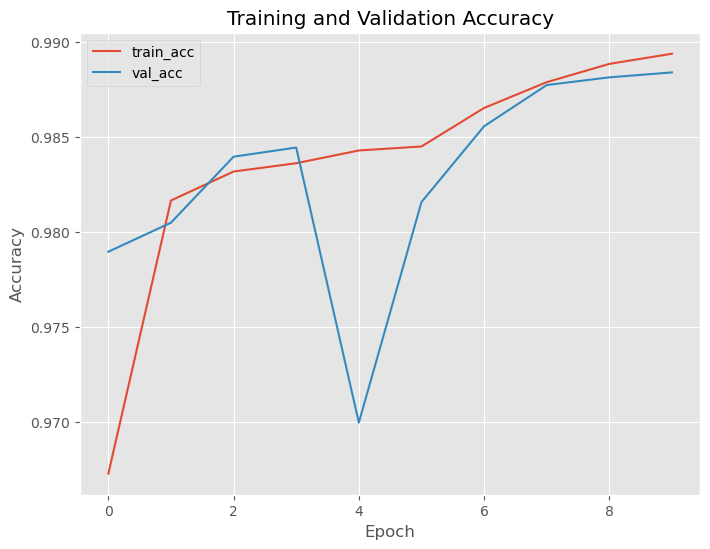

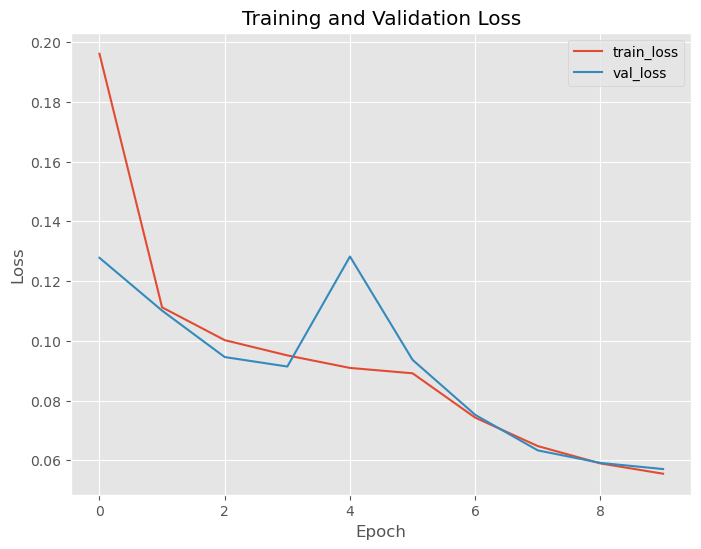

In [53]:
performance_graphs(n_epochs, history.history)

Classification Report: 
              precision    recall  f1-score   support

           0       0.98      0.99      0.99     15725
           1       0.99      0.99      0.99     15802
           2       0.99      0.99      0.99     49692

   micro avg       0.99      0.99      0.99     81219
   macro avg       0.99      0.99      0.99     81219
weighted avg       0.99      0.99      0.99     81219
 samples avg       0.99      0.99      0.99     81219


Confusion Matrix: 


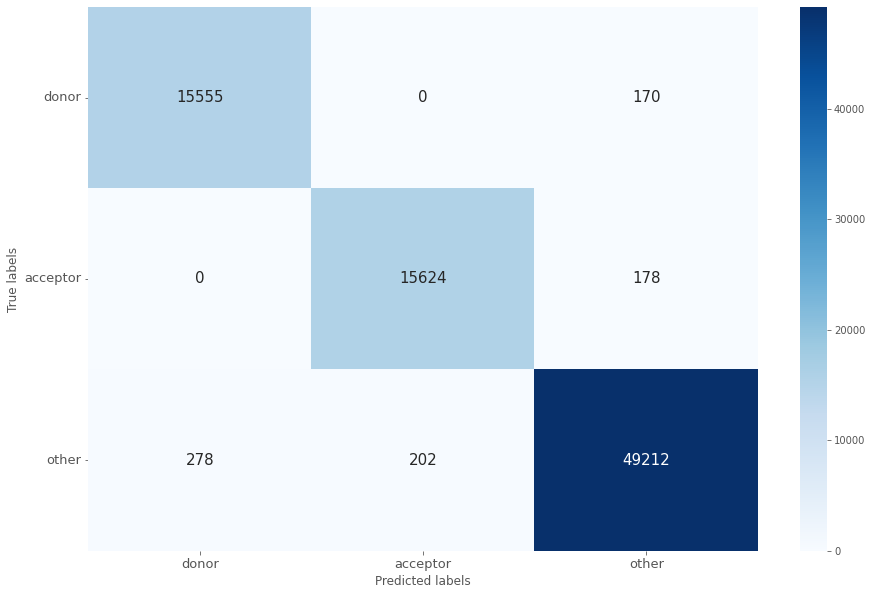

---Calculating other metrics ---
Specificity:  [0.99575534 0.99691212 0.98896184]
Sensitivity:  [0.98918919 0.9887356  0.9903405 ]
Precision:  [0.98244174 0.98723619 0.99297821]
F1:  [0.98580392 0.98798533 0.9916576 ]


In [ ]:
other_metrics(model,x_test,y_test)

Classification Report: 
              precision    recall  f1-score   support

           0       0.98      0.99      0.99     15725
           1       0.99      0.99      0.99     15802
           2       0.99      0.99      0.99     49692

   micro avg       0.99      0.99      0.99     81219
   macro avg       0.99      0.99      0.99     81219
weighted avg       0.99      0.99      0.99     81219
 samples avg       0.99      0.99      0.99     81219


Confusion Matrix: 


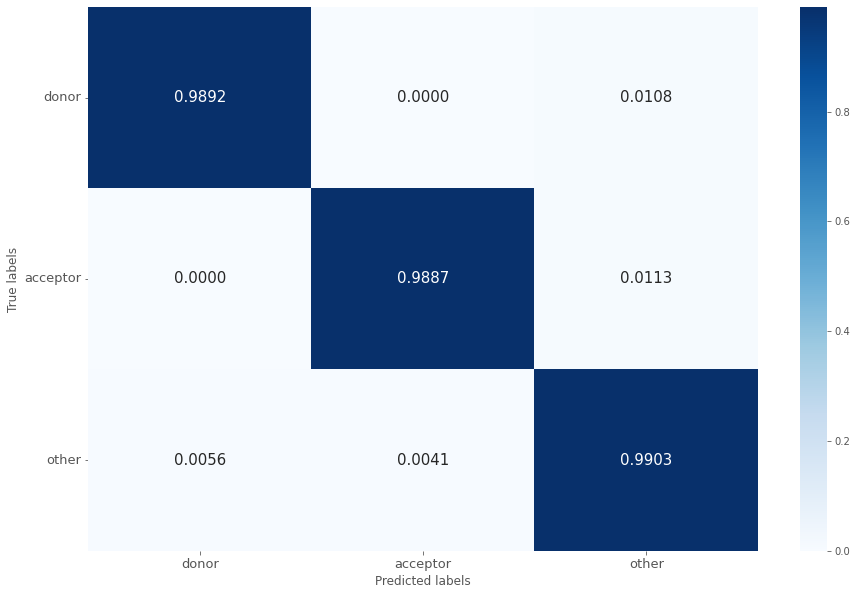

---Calculating other metrics ---
Specificity:  [0.99720277 0.99796748 0.9889624 ]
Sensitivity:  [0.98918919 0.9887356  0.9903405 ]
Precision:  [0.9943762  0.99590548 0.97819551]
F1:  [0.99177591 0.99230759 0.98423054]


In [ ]:
other_metrics(model,x_test,y_test, normalize=True)

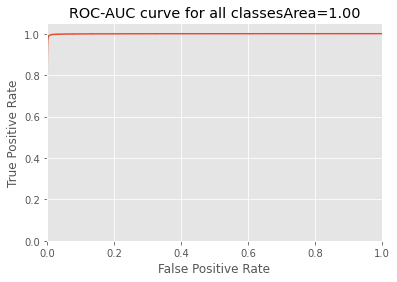

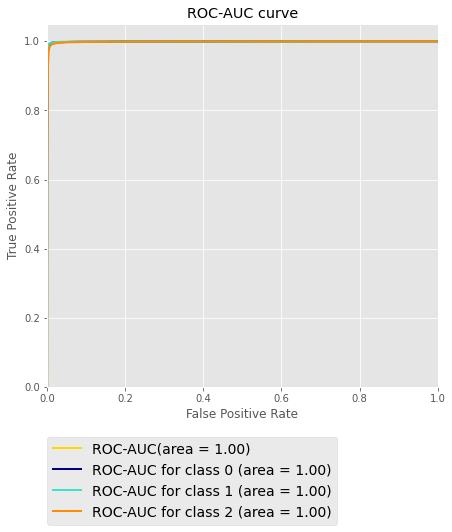

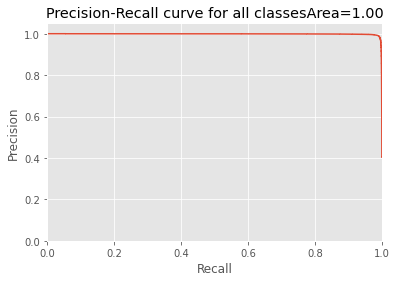

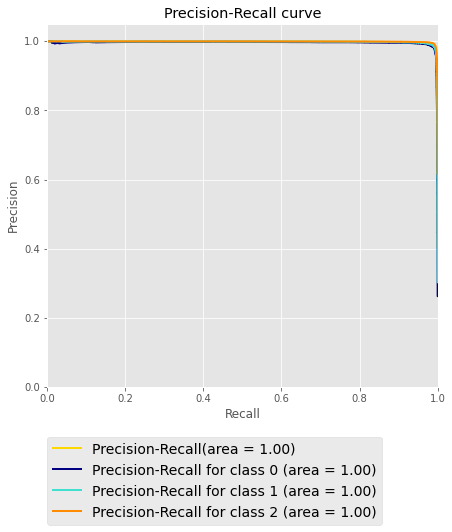

ROC AUC:  {0: 0.9991290790699988, 1: 0.999451393694123, 2: 0.9984752275686642, 'micro': 0.9992203438551738}
PR AUC:  {0: 0.9960868719019345, 1: 0.9978504744279614, 2: 0.9989516958670915, 'micro': 0.9984034135565588}


({0: 0.9960868719019345,
  1: 0.9978504744279614,
  2: 0.9989516958670915,
  'micro': 0.9984034135565588},
 {0: 0.9991290790699988,
  1: 0.999451393694123,
  2: 0.9984752275686642,
  'micro': 0.9992203438551738})

In [ ]:
roc_auc_pr(model, x_test, y_test)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 401, 4)]          0         
                                                                 
 batch_normalization (BatchN  (None, 401, 4)           16        
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 401, 4)            0         
                                                                 
 conv1d (Conv1D)             (None, 401, 16)           720       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 200, 16)          0         
 )                                                               
                                                                 
 batch_normalization_1 (Batc  (None, 200, 16)          64    

# Testing model with other species genome

In [10]:
os.chdir("../other_species/")

In [11]:
def get_np_array_species(flanking_len, species_name):
    """
    Get genomic sequences from other_species directory to test the model.

    Args:
        flanking_len (int): Number of nucleotides on each side of a nucleotide of interest.
        species_name (str): Name of the species to retrieve genomic sequence files.

    Returns:
        tuple: Numpy arrays of one-hot encoded sequences and corresponding labels.
    """
    arr_seqs = []
    y_arr = []
    for type_seq in ['donor', 'acceptor', 'other']:
        file_name = f"{species_name}_{type_seq}_seqs_flank_{flanking_len}.txt"
        with open(file_name, 'r') as file:
            for line in file:
                if line.startswith(">>"):
                    seq = line[2:].strip()
                    one_hot_seq = one_hot_encode(seq)
                    arr_seqs.append(one_hot_seq)
                    y_arr.append({'donor': 0, 'acceptor': 1, 'other': 2}[type_seq])

    return np.array(arr_seqs), np.array(y_arr)

### Mus musculus

In [ ]:
# Get data for Mus musculus
mus_musc_x, mus_musc_y = get_np_array_species(flanking_len=FLANKING_LEN, species_name="mus_musculus")
mus_musc_y = tf.keras.utils.to_categorical(mus_musc_y)

print(f"Input shape: {mus_musc_x.shape}")
print(f"Output shape: {mus_musc_y.shape}")

# Evaluate the model
loss, accuracy = model.evaluate(mus_musc_x, mus_musc_y, verbose=0)

print(f"Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# Calculate additional metrics
other_metrics(model, mus_musc_x, mus_musc_y, normalize=False, graph=False)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


(27580, 401, 4)
(27580, 3)
862/862 [==============================] - 5s 5ms/step - loss: 0.0320 - accuracy: 0.9949

Loss = 0.03199637681245804
Test Accuracy = 0.9949238300323486
Classification Report: 
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      6700
           1       0.99      1.00      0.99      6700
           2       1.00      0.99      1.00     14180

   micro avg       0.99      0.99      0.99     27580
   macro avg       0.99      1.00      0.99     27580
weighted avg       0.99      0.99      0.99     27580
 samples avg       0.99      0.99      0.99     27580

---Calculating other metrics ---
Specificity:  [0.99808429 0.99712644 0.99701493]
Sensitivity:  [0.99701493 0.99701493 0.99294781]
Precision:  [0.99404762 0.99109792 0.99716714]
F1:  [0.99552906 0.99404762 0.995053  ]


### Danio rerio

In [ ]:
d_rerio_x, d_rerio_y = get_np_array_species(flanking_len=FLANKING_LEN, species_name="danio_rerio")
d_rerio_y = tf.keras.utils.to_categorical(d_rerio_y)
print(d_rerio_x.shape)
print(d_rerio_y.shape)
# Evaluate the model
preds = model.evaluate(x = d_rerio_x, y = d_rerio_y)

print()
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

other_metrics(model,d_rerio_x , d_rerio_y, normalize=False, graph=False)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


(14700, 401, 4)
(14700, 3)
460/460 [==============================] - 2s 5ms/step - loss: 0.0873 - accuracy: 0.9891

Loss = 0.08733407407999039
Test Accuracy = 0.9891156554222107
Classification Report: 
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      3560
           1       0.99      0.99      0.99      3560
           2       0.99      0.99      0.99      7580

   micro avg       0.99      0.99      0.99     14700
   macro avg       0.99      0.99      0.99     14700
weighted avg       0.99      0.99      0.99     14700
 samples avg       0.99      0.99      0.99     14700

---Calculating other metrics ---
Specificity:  [0.99640934 0.99820467 0.98595506]
Sensitivity:  [0.98314607 0.98876404 0.99208443]
Precision:  [0.98870056 0.99435028 0.98687664]
F1:  [0.98591549 0.9915493  0.98947368]


### Drosophila melanogaster

In [ ]:
d_mela_x, d_mela_y = get_np_array_species(flanking_len=FLANKING_LEN, species_name="drosophila_melanogaster")
d_mela_y = tf.keras.utils.to_categorical(d_mela_y)
print(d_mela_x.shape)
print(d_mela_y.shape)
#4. Evaluate the model
preds = model.evaluate(x = d_mela_x, y = d_mela_y)

print()
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

other_metrics(model,d_mela_x , d_mela_y, normalize=False, graph=False)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


(2560, 401, 4)
(2560, 3)
80/80 [==============================] - 1s 4ms/step - loss: 0.2042 - accuracy: 0.9609

Loss = 0.20424461364746094
Test Accuracy = 0.9609375
Classification Report: 
              precision    recall  f1-score   support

           0       1.00      0.90      0.95       580
           1       1.00      0.93      0.96       580
           2       0.93      1.00      0.97      1400

   micro avg       0.96      0.96      0.96      2560
   macro avg       0.98      0.94      0.96      2560
weighted avg       0.96      0.96      0.96      2560
 samples avg       0.96      0.96      0.96      2560

---Calculating other metrics ---
Specificity:  [1.        1.        0.9137931]
Sensitivity:  [0.89655172 0.93103448 1.        ]
Precision:  [1.         1.         0.93333333]
F1:  [0.94545455 0.96428571 0.96551724]


### Arabidopsis thaliana

In [ ]:
a_th_x, a_th_y = get_np_array_species(flanking_len=FLANKING_LEN, species_name="arabidopsis_thaliana")
a_th_y = tf.keras.utils.to_categorical(a_th_y)
print(d_rerio_x.shape)
print(a_th_y.shape)
#4. Evaluate the model
preds = model.evaluate(x = a_th_x, y = a_th_y)

print()
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

other_metrics(model,a_th_x , a_th_y, normalize=False, graph=False)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


(14700, 401, 4)
(17760, 3)
555/555 [==============================] - 2s 4ms/step - loss: 0.1409 - accuracy: 0.9550

Loss = 0.14091461896896362
Test Accuracy = 0.954954981803894
Classification Report: 
              precision    recall  f1-score   support

           0       0.99      0.93      0.96      4300
           1       0.99      0.90      0.94      4300
           2       0.93      0.99      0.96      9160

   micro avg       0.95      0.95      0.95     17760
   macro avg       0.97      0.94      0.95     17760
weighted avg       0.96      0.95      0.95     17760
 samples avg       0.95      0.95      0.95     17760

---Calculating other metrics ---
Specificity:  [0.99554235 0.99702823 0.91860465]
Sensitivity:  [0.93488372 0.90232558 0.98908297]
Precision:  [0.98529412 0.98979592 0.92827869]
F1:  [0.95942721 0.94403893 0.9577167 ]


### C.elegans

In [ ]:
c_ele_x, c_ele_y = get_np_array_species(flanking_len=FLANKING_LEN, species_name="C.elegans")
c_ele_y = tf.keras.utils.to_categorical(c_ele_y)
print(c_ele_x.shape)
print(c_ele_y.shape)
#4. Evaluate the model
preds = model.evaluate(x = c_ele_x, y = c_ele_y)

print()
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

other_metrics(model,c_ele_x , c_ele_y, normalize=False, graph=False)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


(13900, 401, 4)
(13900, 3)
435/435 [==============================] - 2s 5ms/step - loss: 0.1883 - accuracy: 0.9324

Loss = 0.18826518952846527
Test Accuracy = 0.932374119758606
Classification Report: 
              precision    recall  f1-score   support

           0       1.00      0.84      0.91      3360
           1       0.99      0.89      0.94      3360
           2       0.89      1.00      0.94      7180

   micro avg       0.93      0.93      0.93     13900
   macro avg       0.96      0.91      0.93     13900
weighted avg       0.94      0.93      0.93     13900
 samples avg       0.93      0.93      0.93     13900

---Calculating other metrics ---
Specificity:  [1.         0.99810247 0.86309524]
Sensitivity:  [0.83928571 0.88690476 0.99721448]
Precision:  [1.         0.99333333 0.88613861]
F1:  [0.91262136 0.93710692 0.93840105]


# Predicting on individual genomic sequences

### Prediction Functions

In [ ]:
def get_gene_position_prediction(indexes_prediction, gene_info, donor=True,topk=True):
  """
  This function returns a dictionary in which the keys are the string positions and the 
  values are the position in which the predicition from the prediction model is. 
  """
  prediction_positions = {}
  positions_of_interest = set()
  donor_indexes = set()
  acceptor_indexes = set()
  topk_dict= {}

  for gene_info_tuple in gene_info:
    found = False
    str_position = gene_info_tuple[0] if donor else gene_info_tuple[1]
    donor_indexes.add(gene_info_tuple[0])
    acceptor_indexes.add(gene_info_tuple[1])
    positions_of_interest.add(str_position)
    for i in range(len(indexes_prediction)):
      curr_position = indexes_prediction[i][0]
      if curr_position == str_position:
        prediction_positions[str_position] = i
        found = True
        break;
    if not found: prediction_positions[str_position] = "Not found"
  
  if topk:
    n = len(prediction_positions) # prediction poistions is the dictionary where we have the positions of each prediction
    no_predictions = len(indexes_prediction)
    n_top10 = math.floor(no_predictions * 0.1)
    n_top25 = math.floor(no_predictions * 0.25)
    n_top50 = math.floor(no_predictions * 0.5)
    n_top65 = math.floor(no_predictions * 0.65)
    n_top75 = math.floor(no_predictions * 0.75)
    n_top85 = math.floor(no_predictions * 0.85)
    n_top95 = math.floor(no_predictions * 0.95)

    counter = 0
    counter_top10 = 0 
    counter_top25 = 0
    counter_top50 = 0
    counter_top65 = 0
    counter_top75 = 0
    counter_top85 = 0
    counter_top95 = 0

    for k in prediction_positions:
      pred = prediction_positions[k]
      if type(pred) != str and  pred < n:
        counter += 1
      if type(pred) != str and  pred < n_top10:
        counter_top10 += 1
      if type(pred) != str and  pred < n_top25:
        counter_top25 += 1
      if type(pred) != str and  pred < n_top50:
        counter_top50 += 1
      if type(pred) != str and  pred < n_top65:
        counter_top65 += 1
      if type(pred) != str and  pred < n_top75:
        counter_top75 += 1
      if type(pred) != str and  pred < n_top85:
        counter_top85 += 1
      if type(pred) != str and  pred < n_top95:
        counter_top95 += 1
    
    try:
      topk_dict["top-k"] = round(counter/n,2)
      topk_dict["top-10%"] = round(counter_top10/n,2)
      topk_dict["top-25%"] = round(counter_top25/n,2)
      topk_dict["top-50%"] = round(counter_top50/n,2)
      topk_dict["top-65%"] = round(counter_top65/n,2)
      topk_dict["top-75%"] = round(counter_top75/n,2)
      topk_dict["top-85%"] = round(counter_top85/n,2)
      topk_dict["top-95%"] = round(counter_top95/n,2)
    except:
      pass

  return prediction_positions, topk_dict

In [ ]:
def get_intron_delimitation(id, flanking_len=5000, return_strand=False):
  info_json = ensRest.getLookupById(id=id,expand=True)
  gene_info = []
  strand = info_json['strand']
  gene_start = info_json['start']
  gene_end = info_json['end']
  try:
    exons = info_json['Exon']
  except: #A.thaliana's genes
    exons = info_json['Transcript'][0]['Exon']
  exons_list = []
  introns_list = []
  for exon in exons:
    if strand == 1:
      exons_list.append((exon['start'], exon['end']))
    else:
      exons_list.append((exon['end'],exon['start']))
  for i in range(len(exons_list)-1):
    if strand == 1:
      intron_start = exons_list[i][1] + 1
      intron_end = exons_list[i+1][0] - 1
    else:
      intron_start = exons_list[i][1] - 1
      intron_end = exons_list[i+1][0] + 1 
    introns_list.append((intron_start,intron_end))

  for intron in introns_list:
    gene_info.append(getting_seq_indexes(gene_start, gene_end, intron[0], intron[1], strand, flanking_len=flanking_len))

  print("Intron positions on string: ", gene_info)
  if return_strand:
    return gene_info, strand
  else:
    return gene_info




In [ ]:
def getting_seq_indexes(gene_start, gene_end, seq_start, seq_end, strand, flanking_len=5000):

    first_index = 0
    second_index = 0
    if strand == 1:
        gene_start -= flanking_len 
        first_index = seq_start - gene_start
        second_index = seq_end - gene_start
    elif strand == -1:
        gene_end += flanking_len
        second_index = gene_end - seq_start
        first_index = gene_end - seq_end
    return (first_index, second_index)

In [ ]:
def transform_sequence_4_prediction(seq, flanking_length=FLANKING_LEN):
  arr_seqs = []
  n = len(seq)
  if n < (flanking_length * 2):
    print("Flanking length: ", flanking_length)
    for i in range(n):
      new_numpy = None
      if i <= flanking_length:
        curr_seq = seq[:i+flanking_length + 1]
        one_hot_seq = one_hot_encode(curr_seq)
        # zeros at the front
        np_zeros_front = np.zeros((flanking_length-i,4))
        n_curr_seq = len(curr_seq)
        #if n_curr_seq <= flanking_length:
        # zeros at the back
        extra = flanking_length - (n_curr_seq - (i+1))
        np_zeros_back = np.zeros((extra,4))
        new_numpy = np.concatenate((np_zeros_front,one_hot_seq,np_zeros_back))
      else:
        curr_seq = seq[i-flanking_length:]
        one_hot_seq = one_hot_encode(curr_seq)
        n_curr_seq = len(curr_seq)
        extra = (2* flanking_length + 1) - n_curr_seq
        np_zeros_back = np.zeros((extra,4))
        new_numpy = np.concatenate((one_hot_seq,np_zeros_back))
          
      arr_seqs.append(new_numpy)
    np_arr_seqs = np.asarray(arr_seqs)
    return np_arr_seqs
  else:
    for i in range(n):
      new_numpy = None
      if i >= flanking_length and i < (n-flanking_length):
        curr_seq = seq[i-flanking_length:i+flanking_length +1]
        new_numpy = one_hot_encode(curr_seq)
        # print(i, " :",one_hot_seq.shape)
      elif i < flanking_length:
        curr_seq = seq[:i+flanking_length + 1]
        one_hot_seq = one_hot_encode(curr_seq)
        # print(i, " :",one_hot_seq.shape)
        np_zeros = np.zeros((flanking_length-i,4))
        new_numpy = np.concatenate((np_zeros,one_hot_seq))
        # print(i, " :",new_numpy.shape)
      elif i >= n-flanking_length:
        curr_seq = seq[i-flanking_length:]
        one_hot_seq = one_hot_encode(curr_seq)
        np_zeros = np.zeros(((2*flanking_length+1)-len(curr_seq),4))
        new_numpy = np.concatenate((one_hot_seq, np_zeros))
        #print(i, " :", new_numpy.shape)
      arr_seqs.append(new_numpy)
    np_arr_seqs = np.asarray(arr_seqs)
    return np_arr_seqs

In [ ]:
def testing_transcripts(transcript_id, model=model, return_arr=False):
  seq_download = ensRest.getSequenceById(id=transcript_id,expand_5prime=5000, expand_3prime=5000)
  seq_str = seq_download["seq"]
  seq_np_arr = transform_sequence_4_prediction(seq_str)
  #gene_info = get_gene_info(intron_file)
  gene_info, strand = get_intron_delimitation(transcript_id, return_strand=True)
  predictions_seq = model.predict(seq_np_arr)
  arr_0, arr_1,arr2 = sorting_predictions(predictions_seq)
  if strand == -1: 
    print("Intron position predicted by the model: ", get_gene_position_prediction(arr_0, gene_info, donor=False))
    print("Intron position predicted by the model: ", get_gene_position_prediction(arr_1, gene_info))
  else:
    print("Intron position predicted by the model: ", get_gene_position_prediction(arr_0, gene_info))
    print("Intron position predicted by the model: ", get_gene_position_prediction(arr_1, gene_info, donor=False))
  if len(gene_info) == 0:
    print("No introns were found on Ensembl transcript id: ", transcript_id)
    if not return_arr:
      print("Predictions made by Deep Splicer: ", arr_0, arr_1)
  
  if return_arr:
    return arr_0, arr_1

In [ ]:
def sorting_predictions(predictions):
  """
  This function returns three arrays, one corresponding to donor, acceptor and other sequences.
  Each element of the array is composed of a tuple of three elements. Each element of the tuple represents:
  1. the string index position of the sequence.
  2.Probability it scored on the te prediction model (0-1)
  3. Which type of position it is
  """
  predictions_summary = predictions.argmax(axis=1)
  unique, counts = np.unique(predictions_summary,return_counts=True)
  print("Number of sequences predicted per index (donor, acceptor,other): ", counts)
  max_preds = [(i,max(predictions[i]),predictions[i].argmax()) for i in range(len(predictions))]
  arr_0 = [pred for pred in max_preds if pred[2]== 0]
  arr_1 = [pred for pred in max_preds if pred[2]== 1]
  arr_2 = [pred for pred in max_preds if pred[2]== 2]

  sort_arr_0 = sorted(arr_0,reverse=True,key= lambda tup: tup[1])
  sort_arr_1 = sorted(arr_1,reverse=True,key= lambda tup: tup[1])
  sort_arr_2 = sorted(arr_2,reverse=True,key= lambda tup: tup[1])
  return sort_arr_0, sort_arr_1, sort_arr_2
 

## Homo sapiens

In [ ]:
#ABCD3
arr_0, arr_1 = testing_transcripts(transcript_id='ENST00000315713', model=model, return_arr=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


Intron positions on string:  [(5110, 45127), (45165, 51295), (51395, 54439), (54529, 60286), (60357, 61663), (61762, 62134), (62259, 64779), (64837, 65044)]
Number of sequences predicted per index (donor, acceptor,other):  [  101   127 70017]
Intron position predicted by the model:  ({5110: 3, 45165: 5, 51395: 2, 54529: 6, 60357: 4, 61762: 9, 62259: 0, 64837: 1}, {'top-k': 0.88, 'top-10%': 1.0, 'top-25%': 1.0, 'top-50%': 1.0, 'top-65%': 1.0, 'top-75%': 1.0, 'top-85%': 1.0, 'top-95%': 1.0})
Intron position predicted by the model:  ({45127: 9, 51295: 1, 54439: 5, 60286: 18, 61663: 3, 62134: 0, 64779: 7, 65044: 36}, {'top-k': 0.62, 'top-10%': 0.75, 'top-25%': 0.88, 'top-50%': 1.0, 'top-65%': 1.0, 'top-75%': 1.0, 'top-85%': 1.0, 'top-95%': 1.0})


In [ ]:
#LRRC42
arr_0, arr_1 = testing_transcripts(transcript_id='ENST00000319223', model=model, return_arr=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


Intron positions on string:  [(5197, 10632), (11120, 16795), (16928, 19002), (19122, 20680), (20770, 20942), (21057, 24942), (25028, 26311)]
Number of sequences predicted per index (donor, acceptor,other):  [   38    57 31721]
Intron position predicted by the model:  ({5197: 0, 11120: 5, 16928: 3, 19122: 1, 20770: 4, 21057: 6, 25028: 2}, {'top-k': 1.0, 'top-10%': 0.43, 'top-25%': 1.0, 'top-50%': 1.0, 'top-65%': 1.0, 'top-75%': 1.0, 'top-85%': 1.0, 'top-95%': 1.0})
Intron position predicted by the model:  ({10632: 8, 16795: 2, 19002: 1, 20680: 7, 20942: 6, 24942: 3, 26311: 0}, {'top-k': 0.71, 'top-10%': 0.57, 'top-25%': 1.0, 'top-50%': 1.0, 'top-65%': 1.0, 'top-75%': 1.0, 'top-85%': 1.0, 'top-95%': 1.0})


In [ ]:
#CFTR
arr_0, arr_1 = testing_transcripts(transcript_id='ENST00000003084', model=model, return_arr=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


Intron positions on string:  [(5123, 29227), (29339, 34008), (34118, 55873), (56090, 59250), (59341, 60222), (60387, 61522), (61649, 65074), (65322, 66990), (67084, 73615), (73799, 84438), (84631, 112713), (112809, 115327), (115415, 116908), (117633, 119904), (120034, 127800), (127839, 128506), (128758, 131648), (131729, 135493), (135645, 136555), (136784, 139587), (139689, 152496), (152746, 167412), (167569, 177816), (177907, 189662), (189836, 190433), (190540, 191882)]
Number of sequences predicted per index (donor, acceptor,other):  [   216    245 198180]
Intron position predicted by the model:  ({5123: 27, 29339: 0, 34118: 31, 56090: 126, 59341: 4, 60387: 21, 61649: 6, 65322: 22, 67084: 11, 73799: 25, 84631: 10, 112809: 1, 115415: 33, 117633: 14, 120034: 19, 127839: 5, 128758: 69, 131729: 12, 135645: 2, 136784: 40, 139689: 7, 152746: 114, 167569: 8, 177907: 9, 189836: 24, 190540: 13}, {'top-k': 0.73, 'top-10%': 0.58, 'top-25%': 0.88, 'top-50%': 0.92, 'top-65%': 1.0, 'top-75%': 1.0,

In [ ]:
#LRRC39
arr_0, arr_1 = testing_transcripts(transcript_id='ENST00000342895', model=model, return_arr=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


Intron positions on string:  [(14632, 5156), (22701, 14870), (23857, 22808), (24905, 24015), (26955, 25043), (28069, 27102), (30748, 28223), (34175, 30889)]
Number of sequences predicted per index (donor, acceptor,other):  [   49    45 39731]
Intron position predicted by the model:  ({5156: 16, 14870: 4, 22808: 0, 24015: 5, 25043: 3, 27102: 8, 28223: 7, 30889: 1}, {'top-k': 0.75, 'top-10%': 0.38, 'top-25%': 0.88, 'top-50%': 1.0, 'top-65%': 1.0, 'top-75%': 1.0, 'top-85%': 1.0, 'top-95%': 1.0})
Intron position predicted by the model:  ({14632: 'Not found', 22701: 2, 23857: 7, 24905: 3, 26955: 6, 28069: 13, 30748: 1, 34175: 5}, {'top-k': 0.75, 'top-10%': 0.38, 'top-25%': 0.75, 'top-50%': 0.88, 'top-65%': 0.88, 'top-75%': 0.88, 'top-85%': 0.88, 'top-95%': 0.88})


In [ ]:
#MTOR
arr_0, arr_1 = testing_transcripts(transcript_id='ENST00000361445', model=model, return_arr=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


Intron positions on string:  [(8127, 5107), (8957, 8304), (10385, 9067), (11358, 10619), (13577, 11560), (19456, 13713), (19817, 19733), (24250, 19927), (25869, 24438), (27003, 25999), (28933, 27249), (29502, 29150), (33285, 29709), (34063, 33409), (35022, 34154), (36116, 35116), (36496, 36252), (38632, 36627), (51316, 38884), (53984, 51404), (54642, 54153), (55076, 54756), (56644, 55240), (58092, 56738), (62847, 58240), (67847, 62991), (68147, 68011), (100033, 68294), (110259, 100110), (117324, 110400), (120759, 117426), (122505, 120876), (122795, 122584), (127892, 122904), (128115, 128019), (133084, 128248), (134353, 133201), (136773, 134472), (137712, 137023), (138599, 137814), (138998, 138697), (139424, 139098), (139744, 139548), (140406, 139928), (140754, 140542), (142917, 140930), (145424, 143054), (146182, 145573), (150464, 146306), (152082, 150548), (152663, 152156), (153097, 152739), (154633, 153234), (157821, 154700), (158180, 157903), (159264, 158262), (160050, 159371)]
Numb

In [ ]:
#BRCA2
arr_0, arr_1 = testing_transcripts(transcript_id='ENST00000380152', model=model, return_arr=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


Intron positions on string:  [(5160, 5913), (6020, 8568), (8818, 14567), (14677, 15592), (15643, 15733), (15775, 15990), (16106, 18934), (18985, 20410), (20523, 21763), (22880, 25756), (30689, 34049), (34146, 36318), (36389, 44352), (44781, 45919), (46102, 47233), (47422, 52014), (52186, 52670), (53026, 59893), (60050, 60447), (60593, 66161), (66284, 68808), (69008, 69241), (69406, 69498), (69638, 84180), (84426, 86389), (86537, 87653)]
Number of sequences predicted per index (donor, acceptor,other):  [  120   149 94492]
Intron position predicted by the model:  ({5160: 23, 6020: 37, 8818: 49, 14677: 1, 15643: 16, 15775: 14, 16106: 25, 18985: 3, 20523: 11, 22880: 20, 30689: 5, 34146: 62, 36389: 9, 44781: 19, 46102: 8, 47422: 18, 52186: 61, 53026: 13, 60050: 10, 60593: 2, 66284: 6, 69008: 4, 69406: 24, 69638: 0, 84426: 30, 86537: 7}, {'top-k': 0.81, 'top-10%': 0.46, 'top-25%': 0.81, 'top-50%': 0.92, 'top-65%': 1.0, 'top-75%': 1.0, 'top-85%': 1.0, 'top-95%': 1.0})
Intron position predicte

## Mus musculus

In [ ]:
#MTOR
arr_0, arr_1 = testing_transcripts(transcript_id='ENSMUST00000057580', model=model, return_arr=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


Intron positions on string:  [(5063, 8631), (8808, 9396), (9506, 10132), (10366, 10926)]
Number of sequences predicted per index (donor, acceptor,other):  [   37    51 16261]
Intron position predicted by the model:  ({5063: 2, 8808: 0, 9506: 7, 10366: 3}, {'top-k': 0.75, 'top-10%': 0.5, 'top-25%': 1.0, 'top-50%': 1.0, 'top-65%': 1.0, 'top-75%': 1.0, 'top-85%': 1.0, 'top-95%': 1.0})
Intron position predicted by the model:  ({8631: 29, 9396: 4, 10132: 2, 10926: 1}, {'top-k': 0.5, 'top-10%': 0.75, 'top-25%': 0.75, 'top-50%': 0.75, 'top-65%': 1.0, 'top-75%': 1.0, 'top-85%': 1.0, 'top-95%': 1.0})


In [ ]:
#Musculin 
arr_0, arr_1 = testing_transcripts(transcript_id='ENSMUST00000027062',model=model, return_arr=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


Intron positions on string:  [(6664, 5761)]
Number of sequences predicted per index (donor, acceptor,other):  [   30    26 12589]
Intron position predicted by the model:  ({5761: 0}, {'top-k': 1.0, 'top-10%': 1.0, 'top-25%': 1.0, 'top-50%': 1.0, 'top-65%': 1.0, 'top-75%': 1.0, 'top-85%': 1.0, 'top-95%': 1.0})
Intron position predicted by the model:  ({6664: 0}, {'top-k': 1.0, 'top-10%': 1.0, 'top-25%': 1.0, 'top-50%': 1.0, 'top-65%': 1.0, 'top-75%': 1.0, 'top-85%': 1.0, 'top-95%': 1.0})


In [ ]:
#Cntnap1
arr_0, arr_1 =testing_transcripts(transcript_id='ENSMUST00000103109',model=model, return_arr=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


Intron positions on string:  [(5287, 6192), (6295, 6381), (6576, 6957), (7106, 7194), (7399, 7773), (7959, 8452), (8597, 9268), (9531, 10190), (10341, 10596), (10769, 11161), (11269, 11391), (11512, 11841), (12046, 12172), (12330, 12413), (12542, 12810), (12997, 13489), (13712, 14005), (14246, 15467), (15822, 15958), (16087, 17221), (17316, 17467), (17714, 17822), (17871, 18325)]
Number of sequences predicted per index (donor, acceptor,other):  [   58    80 24546]
Intron position predicted by the model:  ({5287: 18, 6295: 6, 6576: 21, 7106: 17, 7399: 11, 7959: 10, 8597: 12, 9531: 16, 10341: 3, 10769: 20, 11269: 5, 11512: 1, 12046: 35, 12330: 15, 12542: 'Not found', 12997: 0, 13712: 4, 14246: 7, 15822: 9, 16087: 13, 17316: 2, 17714: 8, 17871: 19}, {'top-k': 0.91, 'top-10%': 0.22, 'top-25%': 0.61, 'top-50%': 0.91, 'top-65%': 0.96, 'top-75%': 0.96, 'top-85%': 0.96, 'top-95%': 0.96})
Intron position predicted by the model:  ({6192: 10, 6381: 5, 6957: 13, 7194: 21, 7773: 16, 8452: 20, 9268:

## Danio rerio

In [ ]:
#slc24a5-201
arr_0, arr_1 = testing_transcripts(transcript_id='ENSDART00000033574', model=model, return_arr=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


Intron positions on string:  [(5217, 7677), (7858, 8145), (8230, 9086), (9191, 9279), (9381, 10489), (10774, 12173), (12381, 17204), (17307, 18358)]
Number of sequences predicted per index (donor, acceptor,other):  [   47    73 23963]
Intron position predicted by the model:  ({5217: 1, 7858: 11, 8230: 4, 9191: 6, 9381: 2, 10774: 0, 12381: 3, 17307: 7}, {'top-k': 0.88, 'top-10%': 0.5, 'top-25%': 0.88, 'top-50%': 1.0, 'top-65%': 1.0, 'top-75%': 1.0, 'top-85%': 1.0, 'top-95%': 1.0})
Intron position predicted by the model:  ({7677: 4, 8145: 5, 9086: 3, 9279: 2, 10489: 1, 12173: 0, 17204: 6, 18358: 8}, {'top-k': 0.88, 'top-10%': 0.88, 'top-25%': 1.0, 'top-50%': 1.0, 'top-65%': 1.0, 'top-75%': 1.0, 'top-85%': 1.0, 'top-95%': 1.0})


In [ ]:
#MTOR
arr_0, arr_1 = testing_transcripts(transcript_id='ENSDART00000075189', model=model, return_arr=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


Intron positions on string:  [(9649, 5059), (11449, 9821), (13609, 11559), (15847, 13843), (16132, 16049), (20743, 16268), (22072, 21020), (24193, 22182), (26169, 24378), (29884, 26299), (32437, 30130), (34441, 32654), (37572, 34648), (40419, 37696), (43174, 40504), (49140, 43268), (51264, 49276), (61599, 51395), (64470, 61851), (68604, 64558), (79100, 68773), (82790, 79214), (85058, 82954), (89303, 85152), (93196, 89451), (95636, 93340), (98047, 95800), (131182, 98194), (138799, 131259), (153958, 138940), (156176, 154060), (162857, 156293), (165897, 162936), (173077, 166006), (174939, 173204), (183827, 175072), (192026, 183944), (194050, 192145), (194689, 194249), (201369, 194791), (203091, 201467), (209447, 203191), (212537, 209571), (215910, 212721), (218867, 216046), (220991, 219043), (227582, 221128), (229026, 227731), (231710, 229150), (231899, 231794), (232048, 231973), (237201, 232124), (237407, 237338), (237796, 237474), (241206, 237878), (241368, 241288), (248395, 241475)]
Nu

## Drosophila melanogaster

In [ ]:
#msi-RF
arr_0, arr_1 = testing_transcripts(transcript_id='FBtr0333664', model=model, return_arr=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


Intron positions on string:  [(5232, 8142), (8612, 52961), (53010, 63765), (63805, 83955), (84485, 88388), (89093, 89151)]
Number of sequences predicted per index (donor, acceptor,other):  [   271    307 101728]
Intron position predicted by the model:  ({5232: 162, 8612: 0, 53010: 2, 63805: 3, 84485: 1, 89093: 21}, {'top-k': 0.67, 'top-10%': 0.83, 'top-25%': 0.83, 'top-50%': 0.83, 'top-65%': 1.0, 'top-75%': 1.0, 'top-85%': 1.0, 'top-95%': 1.0})
Intron position predicted by the model:  ({8142: 'Not found', 52961: 2, 63765: 1, 83955: 19, 88388: 14, 89151: 21}, {'top-k': 0.33, 'top-10%': 0.83, 'top-25%': 0.83, 'top-50%': 0.83, 'top-65%': 0.83, 'top-75%': 0.83, 'top-85%': 0.83, 'top-95%': 0.83})


MTOR

In [ ]:
#MTOR
arr_0, arr_1 = testing_transcripts(transcript_id='FBtr0332464', model=model, return_arr=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


Intron positions on string:  [(5290, 5730), (11867, 11922), (12255, 12312), (12447, 12697)]
Number of sequences predicted per index (donor, acceptor,other):  [   82    86 18418]
Intron position predicted by the model:  ({5290: 0, 11867: 4, 12255: 11, 12447: 3}, {'top-k': 0.5, 'top-10%': 0.75, 'top-25%': 1.0, 'top-50%': 1.0, 'top-65%': 1.0, 'top-75%': 1.0, 'top-85%': 1.0, 'top-95%': 1.0})
Intron position predicted by the model:  ({5730: 3, 11922: 'Not found', 12312: 7, 12697: 2}, {'top-k': 0.5, 'top-10%': 0.75, 'top-25%': 0.75, 'top-50%': 0.75, 'top-65%': 0.75, 'top-75%': 0.75, 'top-85%': 0.75, 'top-95%': 0.75})


## Arabidopsis thaliana

In [ ]:
#AT3G52430
arr_0, arr_1 = testing_transcripts(transcript_id='AT3G52430', model=model, return_arr=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


Intron positions on string:  [(5762, 6862)]
Number of sequences predicted per index (donor, acceptor,other):  [   40    34 13282]
Intron position predicted by the model:  ({5762: 1}, {'top-k': 0.0, 'top-10%': 1.0, 'top-25%': 1.0, 'top-50%': 1.0, 'top-65%': 1.0, 'top-75%': 1.0, 'top-85%': 1.0, 'top-95%': 1.0})
Intron position predicted by the model:  ({6862: 5}, {'top-k': 0.0, 'top-10%': 0.0, 'top-25%': 1.0, 'top-50%': 1.0, 'top-65%': 1.0, 'top-75%': 1.0, 'top-85%': 1.0, 'top-95%': 1.0})


In [ ]:
#Carboxy
arr_0, arr_1 = testing_transcripts(transcript_id='AT1G73300', model=model, return_arr=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


Intron positions on string:  [(5462, 5023), (5827, 5737), (6081, 5974), (6243, 6159), (6455, 6367), (6642, 6559), (6865, 6783), (7050, 6953), (7206, 7120), (7357, 7279), (7547, 7477), (7742, 7662), (7882, 7789)]
Number of sequences predicted per index (donor, acceptor,other):  [   71    82 13001]
Intron position predicted by the model:  ({5023: 62, 5737: 30, 5974: 'Not found', 6159: 54, 6367: 6, 6559: 18, 6783: 16, 6953: 'Not found', 7120: 'Not found', 7279: 3, 7477: 32, 7662: 0, 7789: 52}, {'top-k': 0.23, 'top-10%': 0.23, 'top-25%': 0.31, 'top-50%': 0.54, 'top-65%': 0.54, 'top-75%': 0.62, 'top-85%': 0.69, 'top-95%': 0.77})
Intron position predicted by the model:  ({5462: 7, 5827: 29, 6081: 79, 6243: 4, 6455: 17, 6642: 59, 6865: 'Not found', 7050: 18, 7206: 14, 7357: 40, 7547: 22, 7742: 81, 7882: 'Not found'}, {'top-k': 0.15, 'top-10%': 0.15, 'top-25%': 0.38, 'top-50%': 0.62, 'top-65%': 0.62, 'top-75%': 0.69, 'top-85%': 0.69, 'top-95%': 0.69})


In [ ]:
# TOR
arr_0, arr_1 = testing_transcripts(transcript_id='AT5G01770', model=model, return_arr=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


Intron positions on string:  [(5595, 5521), (5789, 5699), (5954, 5876), (6195, 6114), (6402, 6313), (7047, 6552), (7333, 7203), (7558, 7479), (7730, 7638), (8050, 7833), (8237, 8135), (8665, 8349), (9118, 9020), (9539, 9300), (10212, 10107), (10622, 10531), (11062, 10750), (11286, 11188), (11527, 11433), (11777, 11630), (11972, 11864), (12134, 12055)]
Number of sequences predicted per index (donor, acceptor,other):  [   59    90 18192]
Intron position predicted by the model:  ({5521: 10, 5699: 'Not found', 5876: 32, 6114: 1, 6313: 15, 6552: 7, 7203: 14, 7479: 43, 7638: 17, 7833: 38, 8135: 49, 8349: 3, 9020: 54, 9300: 11, 10107: 6, 10531: 4, 10750: 9, 11188: 'Not found', 11433: 35, 11630: 18, 11864: 2, 12055: 'Not found'}, {'top-k': 0.59, 'top-10%': 0.18, 'top-25%': 0.41, 'top-50%': 0.59, 'top-65%': 0.68, 'top-75%': 0.77, 'top-85%': 0.82, 'top-95%': 0.86})
Intron position predicted by the model:  ({5595: 'Not found', 5789: 36, 5954: 2, 6195: 15, 6402: 4, 7047: 9, 7333: 34, 7558: 30, 773

##C.elegans

In [ ]:
arr_0, arr_1 = testing_transcripts(transcript_id='F53H8.4.1', model=model, return_arr=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


Intron positions on string:  [(6150, 5117), (7004, 6375), (7688, 7212), (7905, 7839), (8482, 8083)]
Number of sequences predicted per index (donor, acceptor,other):  [   55    43 13960]
Intron position predicted by the model:  ({5117: 20, 6375: 0, 7212: 2, 7839: 13, 8083: 1}, {'top-k': 0.6, 'top-10%': 0.6, 'top-25%': 0.6, 'top-50%': 1.0, 'top-65%': 1.0, 'top-75%': 1.0, 'top-85%': 1.0, 'top-95%': 1.0})
Intron position predicted by the model:  ({6150: 14, 7004: 0, 7688: 15, 7905: 1, 8482: 3}, {'top-k': 0.6, 'top-10%': 0.6, 'top-25%': 0.6, 'top-50%': 1.0, 'top-65%': 1.0, 'top-75%': 1.0, 'top-85%': 1.0, 'top-95%': 1.0})


In [ ]:
arr_0, arr_1 = testing_transcripts(transcript_id='ZK20.1.1', model=model, return_arr=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


Intron positions on string:  [(5296, 5964), (6133, 6298), (7034, 7082)]
Number of sequences predicted per index (donor, acceptor,other):  [   54    52 12287]
Intron position predicted by the model:  ({5296: 1, 6133: 9, 7034: 6}, {'top-k': 0.33, 'top-10%': 0.33, 'top-25%': 1.0, 'top-50%': 1.0, 'top-65%': 1.0, 'top-75%': 1.0, 'top-85%': 1.0, 'top-95%': 1.0})
Intron position predicted by the model:  ({5964: 6, 6298: 3, 7082: 12}, {'top-k': 0.0, 'top-10%': 0.33, 'top-25%': 1.0, 'top-50%': 1.0, 'top-65%': 1.0, 'top-75%': 1.0, 'top-85%': 1.0, 'top-95%': 1.0})


# Saving the model

In [12]:
os.chdir("../../models")

In [ ]:
model.save_weights("deep_splicer_weights.h5")
model.save("deep_splicer.h5")